loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


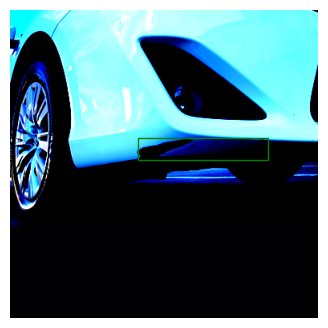

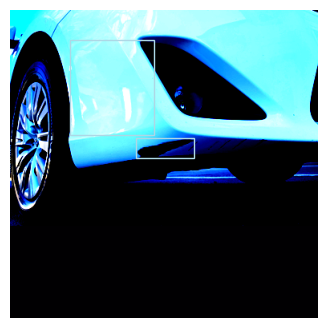

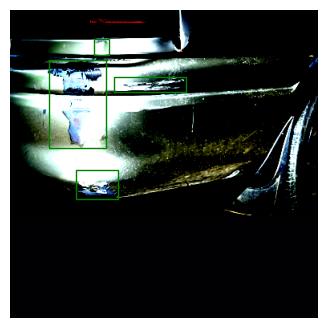

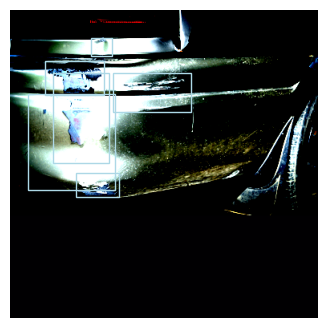

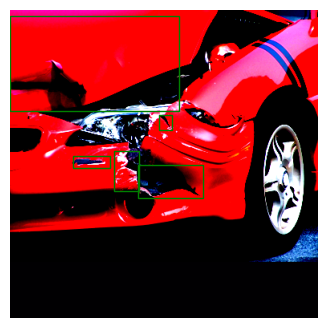

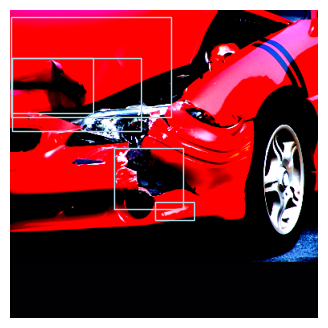

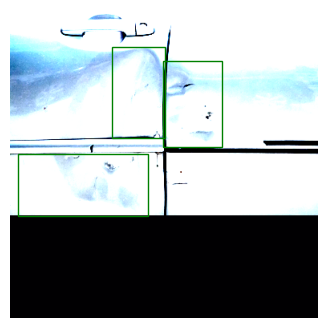

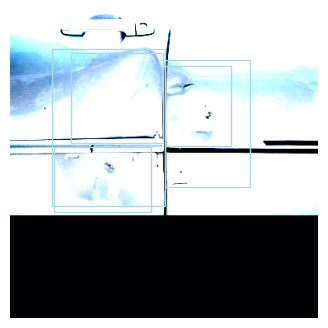

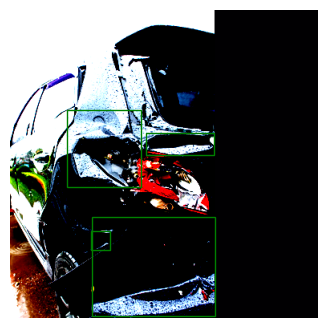

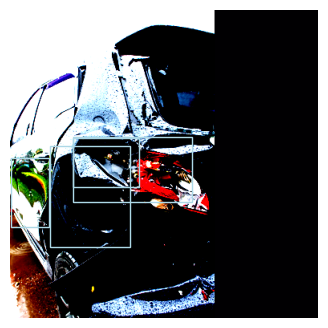

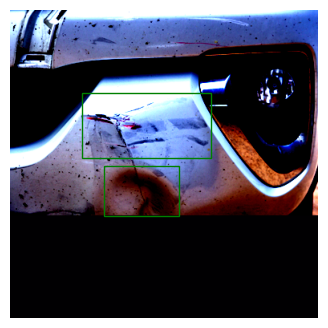

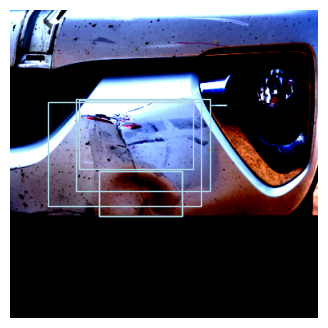

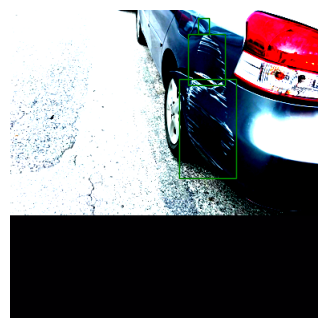

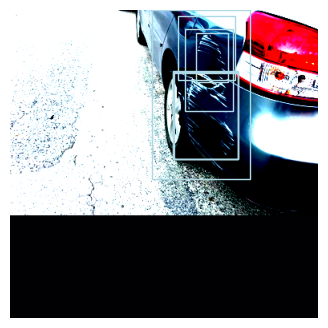

































































































































































































































































































































































































































































































































































































































































































































































































































{'img_idx': tensor([808, 809], device='cuda:0'), 'img_size': tensor([[1000,  667],
        [1000,  603]], device='cuda:0', dtype=torch.int32), 'bbox': tensor([[[ 77.8445, 113.8445, 167.6506, 208.6810]

In [4]:
from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataloader import DataLoader
from torchvision.ops import nms
from effdet import create_model, create_loader
from effdet.data import resolve_input_config, resolve_fill_color
from effdet.bench import DetBenchPredict  # noqa F401
from effdet.anchors import Anchors, AnchorLabeler
from effdet.data.transforms import ResizePad, ImageToNumpy, Compose
from timm.optim._optim_factory import create_optimizer_v2


from ml_carbucks.utils.result_saver import ResultSaver
from ml_carbucks.adapters.BaseDetectionAdapter import (
    BaseDetectionAdapter,
    ADAPTER_PREDICTION,
)
from ml_carbucks.utils.effdet_extension import (
    CocoStatsEvaluator,
    ConcatDetectionDataset,
    create_dataset_custom,
)
from ml_carbucks.utils.logger import setup_logger
from torchmetrics.detection.mean_ap import MeanAveragePrecision  # noqa: F401

from ml_carbucks import DATA_DIR, RESULTS_DIR
from ml_carbucks.utils.inference import plot_img_pred as ppp  # noqa: F401
from ml_carbucks.utils.preprocessing import create_clean_loader  # noqa: F401


logger = setup_logger(__name__)


@dataclass
class EfficientDetAdapter(BaseDetectionAdapter):


    weights: str | Path = ""
    backbone: str = "tf_efficientdet_d0"
    bench_labeler: bool = True

    optimizer: str = "momentum"
    lr: float = 8e-3
    weight_decay: float = 5e-5
    confidence_threshold: float = 0.2

    def save(self, dir: Path | str, prefix: str = "", suffix: str = "") -> Path:
        save_path = Path(dir) / f"{prefix}model{suffix}.pth"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(self.model.model.state_dict(), save_path)
        return save_path

    def clone(self) -> "EfficientDetAdapter":
        return EfficientDetAdapter(
            classes=deepcopy(self.classes),
            weights=self.weights,
            img_size=self.img_size,
            batch_size=self.batch_size,
            epochs=self.epochs,
            backbone=self.backbone,
            bench_labeler=self.bench_labeler,
            optimizer=self.optimizer,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )

    def _predict_preprocess_images_v2(self, images: List[torch.Tensor]):
        input_config = resolve_input_config(self.get_params(), self.model.config)
        fill_color = resolve_fill_color(
            input_config["fill_color"], input_config["mean"]
        )
        transform = Compose(
            [
                ResizePad(
                    target_size=self.img_size,
                    interpolation=input_config["interpolation"],
                    fill_color=fill_color,
                ),
                ImageToNumpy(),
            ]
        )

        batch_list = []
        img_scaled = []

        for img in images:
            if isinstance(img, torch.Tensor):
                img = img.permute(1, 2, 0).cpu().numpy()  # [H,W,C]
            img_pil = Image.fromarray(img.astype(np.uint8))
            img_proc, anno = transform(img_pil, dict())  # no annotations
            batch_list.append(img_proc)
            img_scaled.append(anno.get("img_scale", 1.0))

        batch_np = np.stack(batch_list, axis=0)  # [B,C,H,W]
        batch_tensor = torch.from_numpy(batch_np).float().to(self.device)

        return batch_tensor, img_scaled

    def predict(
        self,
        images: List[torch.Tensor],
        conf_threshold: float = 0.25,
        iou_threshold: float = 0.45,
        max_detections: int = 100,
    ) -> List[ADAPTER_PREDICTION]:

        # NOTE: Something is wrong PROBABLY HERE, it needs to be verified more
        """
        The issue is that predicitons are weird but the results of the evaluation
        are good. So either the evaluation is wrong or the prediction extraction is wrong.
        """
        predictor = DetBenchPredict(deepcopy(self.model.model))
        predictor.to(self.device)
        predictor.eval()
        predictions: List[ADAPTER_PREDICTION] = []

        with torch.no_grad():
            batch_tensor, batch_scales = self._predict_preprocess_images_v2(images)
            outputs = predictor(batch_tensor)

            for i, pred in enumerate(outputs):
                out = pred.cpu()  # move to CPU
                boxes = out[:, :4]
                scores = out[:, 4]
                labels_idx = out[:, 5].long()

                # filter by confidence
                mask = scores >= conf_threshold
                boxes, scores, labels_idx = boxes[mask], scores[mask], labels_idx[mask]

                # apply NMS per image
                keep = nms(boxes, scores, iou_threshold)
                keep = keep[:max_detections]  # take top-k

                boxes = boxes[keep].numpy().copy()
                boxes *= batch_scales[i]

                scores = scores[keep].numpy()
                labels = [self.classes[idx - 1] for idx in labels_idx[keep]]

                predictions.append({"boxes": boxes, "scores": scores, "labels": labels})

        return predictions

    def setup(self) -> "EfficientDetAdapter":
        img_size = self.img_size

        backbone = self.backbone
        weights = self.weights
        bench_labeler = self.bench_labeler

        # NOTE: img size would need to be updated here if we want to change it
        # I dont think it is possible to change it after model creation
        extra_args = dict(image_size=(img_size, img_size))
        self.model = create_model(
            model_name=backbone,
            bench_task="train",
            num_classes=len(self.classes),
            pretrained=weights == "",
            checkpoint_path=str(weights),
            bench_labeler=bench_labeler,
            checkpoint_ema=False,
            **extra_args,
        )

        self.model.to(self.device)

        self.labeler = None
        if bench_labeler is False:
            self.labeler = AnchorLabeler(
                Anchors.from_config(self.model.config),
                self.model.config.num_classes,
                match_threshold=0.5,
            )

        return self

    def fit(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> "EfficientDetAdapter":
        logger.info("Starting training...")
        self.model.train()

        epochs = self.epochs
        opt = self.optimizer
        lr = self.lr
        weight_decay = self.weight_decay

        train_loader = self._create_loader(datasets, is_training=True)

        parser_max_label = train_loader.dataset.parsers[0].max_label  # type: ignore
        config_num_classes = self.model.config.num_classes

        if parser_max_label != config_num_classes:
            raise ValueError(
                f"Number of classes in dataset ({parser_max_label}) does not match "
                f"model config ({config_num_classes})."
                f"Please verify that the dataset is curated (classes IDs start from 1)"
            )

        optimizer = create_optimizer_v2(
            self.model,
            opt=opt,
            lr=lr,
            weight_decay=weight_decay,
        )

        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            _ = self.train_epoch(optimizer, train_loader)  # type: ignore

        return self

    def _create_loader(
        self, datasets: List[Tuple[str | Path, str | Path]], is_training: bool
    ):
        batch_size = self.batch_size

        all_datasets = []
        for img_dir, ann_file in datasets:
            dataset = create_dataset_custom(
                img_dir=img_dir,
                ann_file=ann_file,
                has_labels=True,
            )
            all_datasets.append(dataset)

        concat_dataset = ConcatDetectionDataset(all_datasets)

        input_config = resolve_input_config(self.get_params(), self.model.config)
        loader = create_loader(
            concat_dataset,
            input_size=input_config["input_size"],
            batch_size=batch_size,
            is_training=is_training,
            use_prefetcher=True,
            interpolation=input_config["interpolation"],
            fill_color=input_config["fill_color"],
            mean=input_config["mean"],
            std=input_config["std"],
            num_workers=4,
            distributed=False,
            pin_mem=False,
            anchor_labeler=self.labeler,
            transform_fn=None,
            collate_fn=None,
        )

        return loader

    def train_epoch(
        self, optimizer: torch.optim.Optimizer, loader: DataLoader
    ) -> float:
        self.model.train()

        total_loss = 0.0
        for imgs, targets in tqdm(loader):
            output = self.model(imgs, targets)
            loss = output["loss"]
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return total_loss

    def debug(
        self,
        train_datasets: List[Tuple[str | Path, str | Path]],
        val_datasets: List[Tuple[str | Path, str | Path]],
        results_path: str | Path,
        results_name: str,
    ) -> Dict[str, float]:
        logger.info("Debugging training and evaluation loops...")

        epochs = self.epochs
        train_loader = self._create_loader(train_datasets, is_training=True)
        optimizer = create_optimizer_v2(
            self.model,
            opt=self.optimizer,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )
        saver = ResultSaver(
            path=results_path,
            name=results_name,
        )
        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            total_loss = self.train_epoch(optimizer, train_loader)  # type: ignore
            val_metrics = self.evaluate(val_datasets)
            saver.save(
                epoch=epoch,
                loss=total_loss,
                val_map=val_metrics["map_50_95"],
                val_map_50=val_metrics["map_50"],
            )
            logger.info(
                f"Debug Epoch {epoch}/{epochs} - Loss: {total_loss}, Val MAP: {val_metrics['map_50_95']}"
            )
            saver.plot(show=False)

        return val_metrics  # type: ignore

    def evaluate(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> Dict[str, float]:
        self.model.eval()

        val_loader = self._create_loader(datasets, is_training=False)

        evaluator = CocoStatsEvaluator(val_loader.dataset)
        total_loss = 0.0
        cnt = 10
        metric = MeanAveragePrecision(extended_summary=False, class_metrics=False)
        with torch.no_grad():
            for imgs, targets in val_loader:
                output = self.model(imgs, targets)
                loss = output["loss"]
                total_loss += loss.item()

                evaluator.add_predictions(output["detections"], targets)
                figsize = (4,4)

                for i in range(len(imgs)):
                    cnt -= 1
                    # print(targets)

                    scale = targets["img_scale"][i] if "img_scale" in targets else 1.0
                    print()
                    mask = output["detections"][i][:, 4] > self.confidence_threshold
                    if mask.sum() == 0:
                        bbox = torch.zeros((0, 4), device=self.device)
                        scores = torch.zeros((0,), device=self.device)
                        labels_idx = torch.zeros((0,), dtype=torch.long, device=self.device)
                    else:
                        bbox = output["detections"][i][mask, :4] 
                        scores = output["detections"][i][mask, 4]
                        labels_idx = output["detections"][i][mask, 5].long()

                    gt_mask = targets["cls"][i] > 0
                    if gt_mask.sum() == 0:
                        gt_bbox = torch.zeros((0, 4), device=self.device)
                        gt_labels_idx = torch.zeros((0,), dtype=torch.long, device=self.device)
                    else:
                        gt_bbox_yxyx = targets["bbox"][i][gt_mask] * scale
                        gt_bbox_xyxy = torch.zeros_like(gt_bbox_yxyx)
                        gt_bbox_xyxy[:, 0] = gt_bbox_yxyx[:, 1]
                        gt_bbox_xyxy[:, 1] = gt_bbox_yxyx[:, 0]
                        gt_bbox_xyxy[:, 2] = gt_bbox_yxyx[:, 3]
                        gt_bbox_xyxy[:, 3] = gt_bbox_yxyx[:, 2]
                        gt_bbox = gt_bbox_xyxy
                        gt_labels_idx = targets["cls"][i][gt_mask].long()

                    if cnt >= 0:
                        mask = output["detections"][i][:, 4] > 0.3
                        if mask.sum() == 0:
                            continue
                        
                        ppp(imgs[i], gt_bbox/scale, coords="xyxy", color="green", figsize=figsize)
                        ppp(imgs[i], bbox/scale, coords="xyxy", color="lightblue", figsize=figsize)
                

                    metric.update(
                        [
                            {
                                "boxes": bbox,
                                "scores": scores,
                                "labels": labels_idx,
                            }
                        ],
                        [
                            {
                                "boxes": gt_bbox,
                                "labels": gt_labels_idx,
                            }
                        ],
                    )
                    # h, w = imgs.shape[2:]
                    # print("img size:", (w, h))
                    # print("bbox range:", bbox.min().item() if bbox.numel() else 0, bbox.max().item() if bbox.numel() else 0)
                    # print("gt range:", gt_bbox.min().item() if gt_bbox.numel() else 0, gt_bbox.max().item() if gt_bbox.numel() else 0)

                #     print(f"bbox: {bbox}, scores: {scores}, labels: {labels_idx}, gt_bbox: {gt_bbox}, gt_labels: {gt_labels_idx}")
                # print(evaluator.evaluate())
                # print("----")
                # print("Intermediate MAP:", metric.compute())
                # raise ValueError("stop")

        print(targets)
        mresults = metric.compute()
        print("Metric results:", mresults)
        print("Metric keys:", mresults.keys())
        results = evaluator.evaluate()
        metrics = {
            "map_50": results[1],
            "map_50_95": results[0],
        }
        return metrics

train_datasets = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "train",
        DATA_DIR / "car_dd_testing" / "instances_train_curated.json",
    )
]
val_datasets = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_val_curated.json",
    )
]

emodel = EfficientDetAdapter(
    classes=["scratch", "dent", "crack"],
    **{
        "img_size": 384,
        "batch_size": 8,
        "epochs": 6,
        "optimizer": "momentum",
        "lr": 0.003459928723120903,
        "weight_decay": 0.0001302610542371722,
    },
    weights="/home/bachelor/ml-carbucks/results/debug/efficientdet/model.pth"
)




emodel.setup()

# --- TRAINING ---
# emodel.fit(train_datasets) # type: ignore
# save_path = emodel.save(RESULTS_DIR / "debug" / "efficientdet")

# --- EVALUATION ---
eres = emodel.evaluate(val_datasets) # type: ignore
# print(eres)

# print("here")

# loader = create_loader(val_datasets, shuffle=False, transforms=None, batch_size=8)  # type: ignore


# metric = MeanAveragePrecision()
# for batch in loader:
#     images, targets = batch
#     outputs = emodel.predict(images)
#     metric.update(outputs, targets)

# final_metrics = metric.compute()
# print(final_metrics)

